因為tensorflow下載一直有問題，所以需要在colab上跑

---



In [1]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [2]:
import os
import numpy as np


**1. Import required packages** 

In [3]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [53]:
from google.colab import files
# 上傳csv檔案,在run此code前請先幫我載入助教提供的csv檔案(SPAM.csv)
uploaded = files.upload()

Saving SPAM.csv to SPAM (2).csv


**2.Load and explore the spam data**

In [5]:
import io
import pandas as pd
messages = pd.read_csv(io.BytesIO(uploaded['SPAM.csv']))
messages[:3] #顯示前面三列資料

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
messages.describe()
#視覺化可用數據

,Category,Message
count,5459,5459
unique,2,5056
top,ham,"Sorry, I'll call later"
freq,4713,30


In [7]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])
#顯示有多少重複地訊息 並顯示前五項

    Category                                            Message
102      ham  As per your request 'Melle Melle (Oru Minnamin...
152      ham  As per your request 'Melle Melle (Oru Minnamin...
204      ham  As I entered my cabin my PA said, '' Happy B'd...
220      ham                             Sorry, I'll call later
323      ham                   No calls..messages..missed calls


In [8]:
messages.groupby('Category').describe().T
#顯示最常見及最少見的垃圾訊息

Category                           ham                                               spam
Message count                     4713                                                746
        unique                    4416                                                640
        top     Sorry, I'll call later  Please call our customer service representativ...
        freq                        30                                                  4

**3.將ham及spam資料分別放到不同的DATAFRAME，並將其轉換為 numpy 數組以生成 WordCloud。**
WordCloud可以將重複出現的關鍵詞視覺化呈現，用於匯總用戶生成的標籤或一個網站的文字內容，我們就可以一目瞭然不同分類中常見的關鍵字。

In [9]:
# Get all the ham and spam emails
ham_msg = messages[messages.Category =='ham']
spam_msg = messages[messages.Category =='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.Message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.Message.to_numpy().tolist())

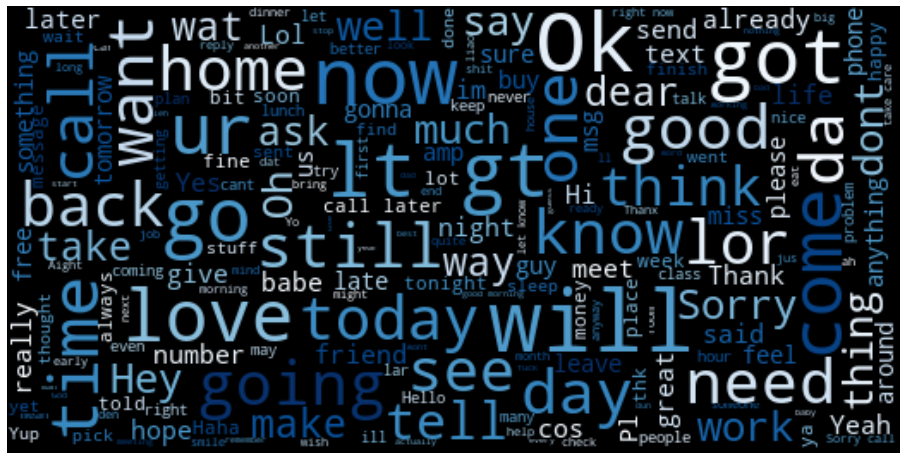

In [10]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

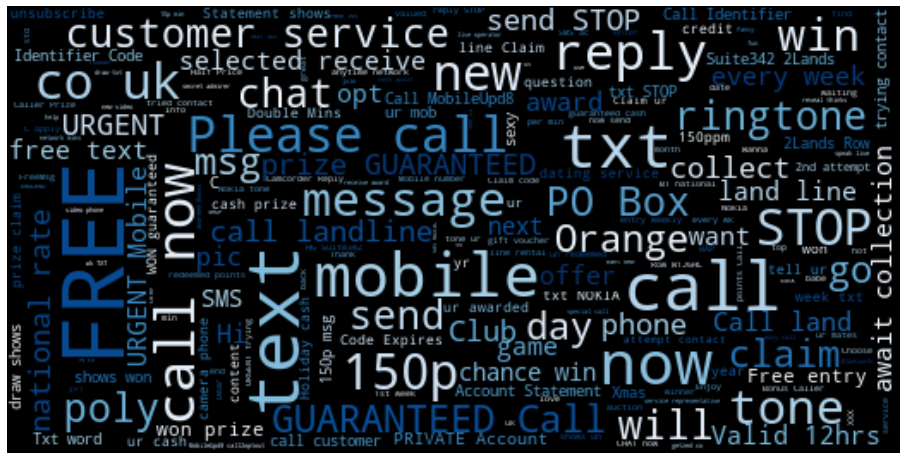

In [11]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.82855930405262

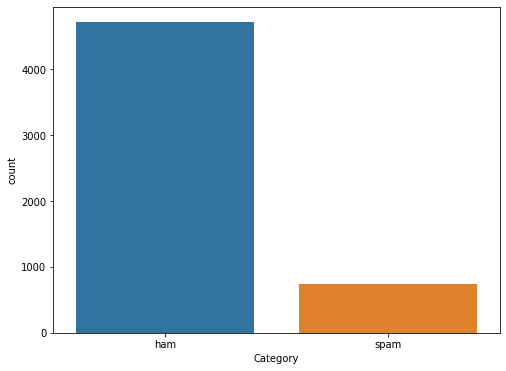

In [12]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.Category)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

# **#指定功課**

In [13]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)


(746, 2) (746, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

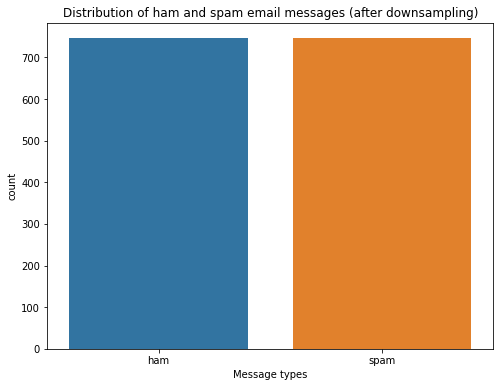

In [14]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.Category)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [15]:
# Get length column for each text
msg_df['text_length'] = msg_df['Message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('Category').mean()
labels

,text_length
Category,
ham,66.541555
spam,137.875335


In [16]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['Category'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['Message'], msg_label, test_size=0.2, random_state=434)

In [17]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [18]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [35]:
# Get the word_index 
word_index = tokenizer.word_index


In [20]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4014 unique tokens in training data. 


In [21]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [22]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)


Shape of training tensor:  (1193, 50)
Shape of testing tensor:  (299, 50)


In [23]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])



(29, 24)

In [24]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [25]:
print(training_padded[0])

[ 22   6   2  35   1  33   8 414  19 117 415 416  92   2 379  24   8  71
  11   1   1   1   1  87  30   1  40   1 318   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [26]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [27]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [30]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6877 - accuracy: 0.7100 - val_loss: 0.6790 - val_accuracy: 0.8328 - 980ms/epoch - 26ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6647 - accuracy: 0.8558 - val_loss: 0.6476 - val_accuracy: 0.8462 - 92ms/epoch - 2ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6138 - accuracy: 0.8676 - val_loss: 0.5828 - val_accuracy: 0.8629 - 92ms/epoch - 2ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5286 - accuracy: 0.8885 - val_loss: 0.4953 - val_accuracy: 0.8662 - 95ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4339 - accuracy: 0.8935 - val_loss: 0.4140 - val_accuracy: 0.8696 - 113ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3510 - accuracy: 0.9145 - val_loss: 0.3553 - val_accuracy: 0.8763 - 147ms/epoch - 4ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2910 - accuracy: 0.9153 - val_loss: 0.3084 - val_accuracy: 0.8896 - 124ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2456 - accuracy: 0.9279 - val_loss: 0.2767 - val_accuracy: 0.8997 - 111ms/epoch - 3ms/step
Epoch 9/30
38/38 -

In [31]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)


10/10 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.9431


[0.14541222155094147, 0.9431437849998474]

In [32]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

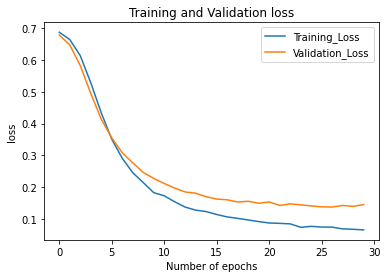

In [33]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

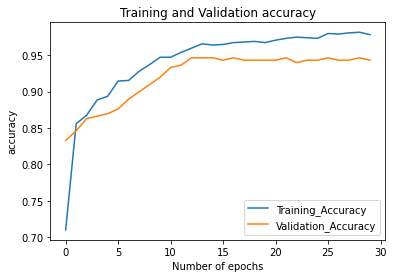

In [34]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# **#指定功課**

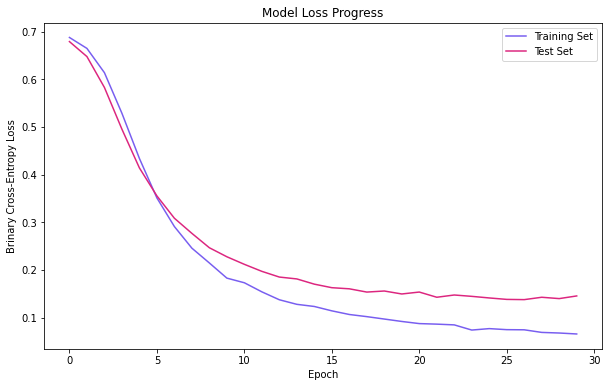

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='#785ef0')
plt.plot(history.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
#plt.savefig('ch.5.rnn.imdb.loss.png', dpi=350, bbox_inches='tight')
plt.show()


# **#指定功課**

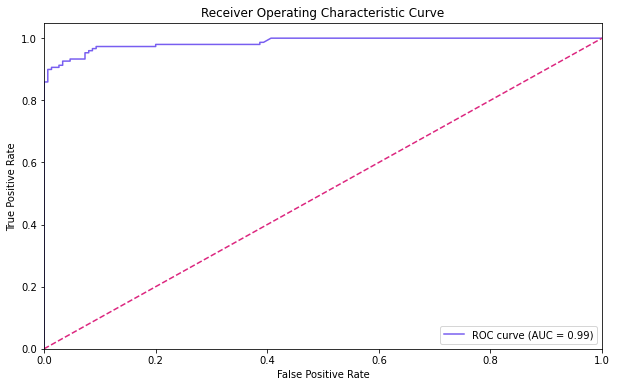

Threshold value is: 0.35193
0.9464205816554809
[[145   5]
 [ 11 138]]


In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_hat = model.predict(testing_padded)

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(test_labels, y_hat)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='#785ef0', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#dc267f', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
#plt.savefig('ch.13.lstm.imdb.roc.png', dpi=350, bbox_inches='tight')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
y_pred = np.where(y_hat>=optimal_threshold, 1, 0)
print(balanced_accuracy_score(test_labels, y_pred))
print(confusion_matrix(test_labels, y_pred))

# **#指定功課**

Text(30.5, 0.5, 'predicted label')

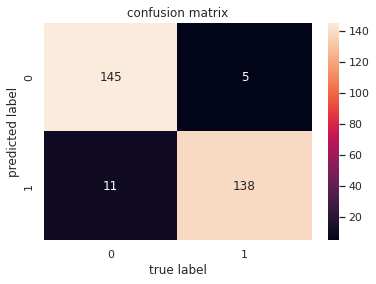

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(test_labels,y_pred)
sns.heatmap(C2,annot=True, ax=ax, fmt='g')

ax.set_title('confusion matrix') #標題
ax.set_xlabel('true label') #x軸
ax.set_ylabel('predicted label') #y軸

同時儲存結構與權重，檔案的類別為HDF5。

In [55]:
from keras.models import load_model

model.save('model.h5') 